In [1]:
## Imports and Seed
import os
import glob
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

# Set random seed for reproducibility
torch.manual_seed(22)
np.random.seed(22)
random.seed(22)

In [2]:
## TensorDataset Conversion for NPY Files
#TODO: Replace 'path_to_load' with directory path.
path_to_load = r'npys/'
train_data_tot_np = np.load(r'{}X_train.npy'.format(path_to_load))
train_labels_tot_np = np.load(r'{}y_train.npy'.format(path_to_load))
val_data_tot_np = np.load(r'{}X_train.npy'.format(path_to_load))
val_labels_tot_np = np.load(r'{}y_train.npy'.format(path_to_load))
test_data_tot_np = np.load(r'{}X_test.npy'.format(path_to_load))
test_labels_tot_np = np.load(r'{}y_test.npy'.format(path_to_load))

# IMPORTANT: The new labels are sinusoidal representations: 
# [ sin(2*pi*phi/100), cos(2*pi*phi/100) ].
# Hence, we convert the labels to float32 (not long) and expect two outputs.
train_dataset = TensorDataset(torch.tensor(train_data_tot_np, dtype=torch.float32),
                              torch.tensor(train_labels_tot_np, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_data_tot_np, dtype=torch.float32),
                              torch.tensor(val_labels_tot_np, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data_tot_np, dtype=torch.float32),
                              torch.tensor(test_labels_tot_np, dtype=torch.float32))

batch_size = 128 #TODO: Set batch size.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Get a batch from the train_loader
batch_data, batch_labels = next(iter(train_loader))
print("Batch shape:", batch_data.shape)
print("Number of batches:", len(train_loader))
print("Total samples:", len(train_loader.dataset))
print(batch_data.shape[-1])
window_size = batch_data.shape[-1]
num_windows = batch_data.shape[0]
print("Label shape:", batch_labels.shape)
batch_data, batch_labels = next(iter(test_loader))
print("Batch shape:", batch_data.shape)
print("Label shape:", batch_labels.shape)
print("Number of batches:", len(test_loader))
print("Total samples:", len(test_loader.dataset))




Batch shape: torch.Size([128, 12, 200])
Number of batches: 16
Total samples: 2029
200
Label shape: torch.Size([128, 2])
Batch shape: torch.Size([128, 12, 200])
Label shape: torch.Size([128, 2])
Number of batches: 4
Total samples: 508


In [4]:
## Baseline CNN Model for Gait Phase Estimation (Regression)
class BaselineGaitPhaseCNN(nn.Module):
    def __init__(
        self,
        num_channels=12,      # Number of input channels (e.g., 12 for shank+thigh IMU)
        sequence_length=window_size,  # Input time window length
        output_dim=2,         # Regression output dimension now 2 for [sin, cos]
        conv_filters=[32, 64],# Filters for each conv block (2 blocks in this example)
        kernel_size=3,        # Kernel size for all conv layers
        stride=1,             # Stride for all conv layers
        padding=0,            # Padding for all conv layers
        dilation=1,           # Dilation for all conv layers
        pool_size=2,          # Max-pooling factor
        hidden_units=100,     # Units in the first fully connected layer
        dropout_rate=0.5,     # Dropout probability
        activation='relu'     # Activation function: 'relu', 'sigmoid', or 'tanh'
    ):

        super(BaselineGaitPhaseCNN, self).__init__()
        
        self.num_channels = num_channels
        self.activation_choice = activation.lower()
        self.conv_blocks = nn.ModuleList()
        
        # Track current number of channels and current sequence length.
        in_channels = num_channels
        L = sequence_length

        # Function to calculate output length after a 1D convolution (with dilation)
        def conv_output_length(L_in, kernel_size, stride, padding, dilation):
            return (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

        # Helper function to choose an activation function
        def get_activation_fn(act):
            if act == 'relu':
                return nn.ReLU()
            elif act == 'sigmoid':
                return nn.Sigmoid()
            elif act == 'tanh':
                return nn.Tanh()
            else:
                raise ValueError("Unsupported activation function. Choose 'relu', 'sigmoid', or 'tanh'.")
        
        act_fn = get_activation_fn(self.activation_choice)
        
        # Build each convolutional block
        for out_channels in conv_filters:
            # Convolution + BatchNorm + Activation + MaxPool
            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding,
                          dilation=dilation),
                nn.BatchNorm1d(out_channels),
                act_fn,
                nn.MaxPool1d(pool_size)
            )
            self.conv_blocks.append(block)
            
            # Update sequence length after convolution and pooling
            L_conv = conv_output_length(L, kernel_size, stride, padding, dilation)
            L_pool = L_conv // pool_size
            L = L_pool
            
            # Update for next block
            in_channels = out_channels
        
        # Flattened size after all convolutional blocks
        flattened_size = in_channels * L
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, output_dim)
        
        # Activation for FC layers using the same activation choice
        self.fc_activation = get_activation_fn(self.activation_choice)
        
    def forward(self, x):

        print("Input shape:", x.shape)
        
        # If the printed shape shows (batch_size, 12, window_size), then no rearrangement is necessary. 
        # However, if you see (batch_size, window_size, 12), then you would need to transpose x using:
        # x = x.transpose(1, 2)
        
        # Pass through each convolutional block
        for block in self.conv_blocks:
            x = block(x)
        
        # Flatten the features using torch.flatten
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = self.fc_activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [5]:
## Training and Evaluation Functions (Regression) with Early Stopping
def train_model(model, device, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    """
    Train the model with early stopping and return the best model along with loss histories.
    """
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    epochs_since_improvement = 0
    
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * data.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)
        
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        # Early stopping: if no improvement for 'patience' epochs, break.
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_weights)
    return model, train_loss_history, val_loss_history

def test_model(model, device, test_loader, criterion):
    """
    Evaluate the model on the test set and return the average test loss.
    """
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * data.size(0)
    test_loss = running_test_loss / len(test_loader.dataset)
    return test_loss

Running on device: cpu
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([109, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torc

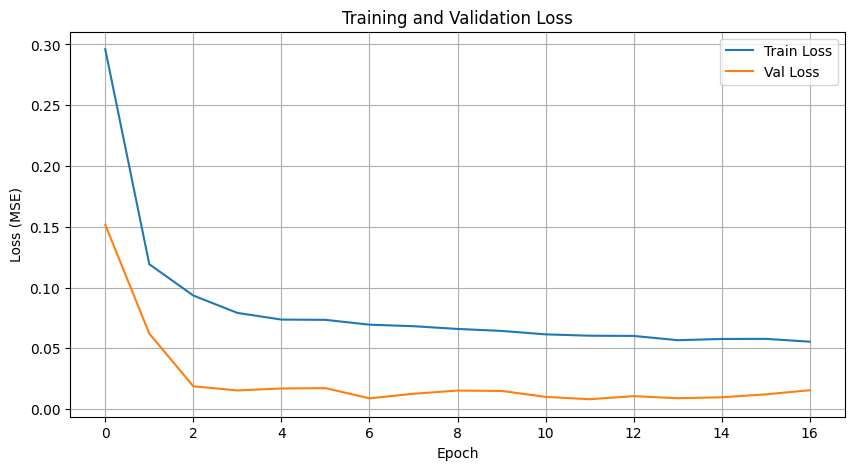

Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([128, 12, 200])
Input shape: torch.Size([124, 12, 200])
Test Loss (MSE): 0.0094


In [ ]:
## Main: One-Subject-Out Cross-Validation Setup and Training
# # Define dataset root directory
# dataset_root = r"dataset"  #TODO: Update with actual data directory

# # Get list of subject folders
# all_subjects = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
# all_subjects.sort()
# print("Subjects found:", all_subjects)

# # One-subject-out split (for demonstration; loop over all subjects for full CV)
# test_subject = all_subjects[0]
# train_subjects = all_subjects[1:]
# print(f"\nTraining on subjects: {train_subjects}")
# print(f"Testing on subject: {test_subject}")

# Hyperparameters
sequence_length = window_size
batch_size = batch_size # so called `num_windows`
num_epochs = 30
learning_rate = 1e-3
dropout_rate = 0.5
patience = 5  # Early stopping patience

# Hyperparameter tuning for optimizer and loss function:
hyperparams = {
    "optimizer": "adam",       # Options: "adam", "sgd"
    "loss_function": "mse",      # Options: "mse", "mae", "huber"
}

# Instantiate the model with output_dim=2 for sinusoidal representation.
model = BaselineGaitPhaseCNN(num_channels=12, sequence_length=sequence_length, output_dim=2, dropout_rate=dropout_rate)

# Choose the loss function
loss_fn = hyperparams["loss_function"].lower()
if loss_fn == "mse":
    criterion = nn.MSELoss()
elif loss_fn == "mae":
    criterion = nn.L1Loss()
elif loss_fn == "huber":
    criterion = nn.SmoothL1Loss()
else:
    raise ValueError("Unsupported loss function. Choose 'mse', 'mae', or 'huber'.")

# Choose the optimizer
optim_choice = hyperparams["optimizer"].lower()
if optim_choice == "adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optim_choice == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
else:
    raise ValueError("Unsupported optimizer. Choose 'adam' or 'sgd'.")

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device:", device)

# Train the model with early stopping
model, train_loss_hist, val_loss_hist = train_model(
    model, device, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=patience)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss = test_model(model, device, test_loader, criterion)
print(f"Test Loss (MSE): {test_loss:.4f}")